# Trabajo Final - Redes Neuronales

## Importo las librerias necesarias


In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn as skl
import pandas as pd
import json

In [3]:
# 1.3)
import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Red neuronal autoencoder convolucional de varias capas

### Importo data set

In [5]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                                ])

PATH = 'MNIST_data/'
train_set_orig = datasets.FashionMNIST(PATH, download=True, train=True, transform=transform)
valid_set_orig = datasets.FashionMNIST(PATH, download=True, train=False, transform=transform)

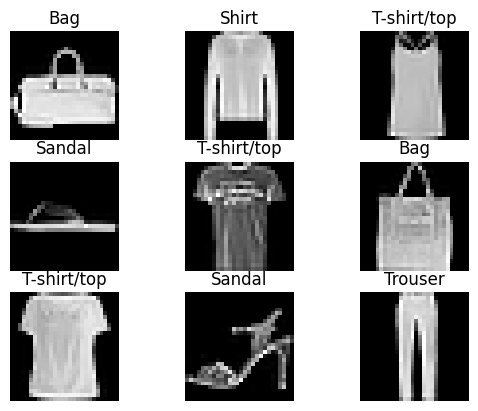

In [6]:
figure = plt.figure()
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    j = torch.randint(len(train_set_orig), size=(1,)).item()
    image, label = train_set_orig[j]
    figure.add_subplot(rows, cols, i)
    plt.title(train_set_orig.classes[label])
    plt.axis("off")
    plt.imshow(image.squeeze(), cmap="gray")
plt.show()

### Creo data set personalizado

In [7]:
class CustomDataset():
    def __init__(self, dataset):
        self.dataset = dataset
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, i):
        image, label = self.dataset[i]
        input = image
        output = image
        return input, output

In [8]:
train_set = CustomDataset(train_set_orig)
valid_set = CustomDataset(valid_set_orig)

### Parte 1: red autoencoder

In [11]:
def to_ndim(ndim, i):
    '''
    Mapea un entero i a una tupla (i, i, ..., i) de longitud ndim.
    '''
    if isinstance(i, int):
        return tuple([i]*ndim)
    else:
        return i

to_ndim(3, 10)

(10, 10, 10)

In [15]:
def conv_size(ndim, in_size, kernel_size, stride=1, padding=0, dilation=1):
    '''
    Calcula el tamaño de la salida de una capa de convolución.
    '''
    in_size = to_ndim(ndim, in_size)
    kernel_size = to_ndim(ndim, kernel_size)
    stride = to_ndim(ndim, stride)
    padding = to_ndim(ndim, padding)
    dilation = to_ndim(ndim, dilation)
    out_size = [(in_size[i] + 2*padding[i] - dilation[i]*(kernel_size[i] - 1) - 1)//stride[i] + 1 for i in range(ndim)]
    return out_size

def conv_tr_size(ndim, in_size, kernel_size, stride=1, padding=0, dilation=1, output_padding=0):
    '''
    Calcula el tamaño de la salida de una capa de convolución transpuesta.
    '''
    in_size = to_ndim(ndim, in_size)
    kernel_size = to_ndim(ndim, kernel_size)
    stride = to_ndim(ndim, stride)
    padding = to_ndim(ndim, padding)
    dilation = to_ndim(ndim, dilation)
    output_padding = to_ndim(ndim, output_padding)
    out_size = [(in_size[i] - 1)*stride[i] - 2*padding[i] + dilation[i]*(kernel_size[i] - 1) + output_padding[i] + 1 for i in range(ndim)]
    return out_size

In [16]:
conv_tr_size(2, 13, 4, stride=2)

[28, 28]

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, n=64, p=0.2):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, n),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(n, 28*28),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Unflatten(1, (1, 28, 28))
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

In [ ]:
class Autoencoder_Conv(nn.Module):
    def __init__(self, n=28*28, p=0.2):
        super().__init__()
        self.n = n
        self.p = p
        # encoder
        self.encoder = nn.Sequential(
            # conv1
            nn.Conv2d(1, 16, kernel_size=3),
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.MaxPool2d(2, 2),
            # conv2
            nn.Conv2d(16, 32, kernel_size=3),
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.MaxPool2d(2, 2),
            # lineal
            nn.Flatten(),
            nn.Linear(32*5*5, self.n),
            nn.ReLU(),
            nn.Dropout(self.p)
        )
        # decoder
        self.decoder = nn.Sequential(
            # lineal
            nn.Linear(self.n, 32*5*5),
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.Unflatten(1, (32, 5, 5)),
            # conv2
            nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2,
                               padding=2, output_padding=0, dilation=2),
            nn.ReLU(),
            nn.Dropout(self.p),
            # conv1
            nn.ConvTranspose2d(16, 1, kernel_size=6, stride=2,
                               padding=1, output_padding=0, dilation=1),
            nn.ReLU(),
            nn.Dropout(self.p)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
# 2.6)
n = 64
p = 0.2
autoencoder_conv = Autoencoder_Conv(n, p)
model = autoencoder_conv

In [ ]:
autoencoder_conv.encoder

In [ ]:
autoencoder_conv.decoder

In [ ]:
def batch(x):
    return x.unsqueeze(0)  # 28x28 -> 1x28x28


def unbatch(x):
    return x.squeeze().detach().cpu().numpy()  # 1x28x28 -> 28x28

In [ ]:
image, _ = train_set[0]
pred = model(batch(image))
print(image.size())
print(unbatch(pred).shape)
print(pred.size())
print(unbatch(pred).shape)

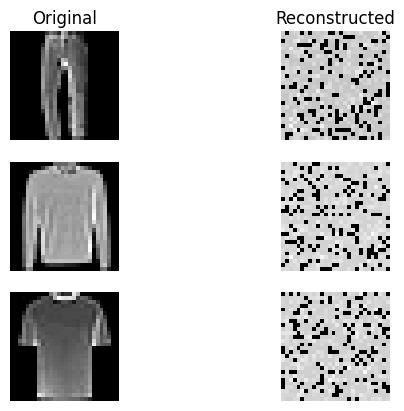

In [25]:
# miramos que imagene predice el modelo sin entrenar
figure = plt.figure()
rows, cols = 3, 2
i = 0
for row in range(1, rows + 1):
    j = torch.randint(len(train_set), size=(1,)).item()
    i += 1
    image, _ = train_set[j]
    figure.add_subplot(rows, cols, i)
    if row == 1:
        plt.title('Original')
    plt.axis("off")
    plt.imshow(image.squeeze(), cmap="gray")
    i += 1
    figure.add_subplot(rows, cols, i)
    if row == 1:
        plt.title('Reconstructed')
    plt.axis("off")
    image_pred = unbatch(model(batch(image)))
    plt.imshow(image_pred.squeeze(), cmap="gray")
plt.show()

## Parte 2: entrenenado el autoencoder

In [ ]:
# 5.1)
def train_model(dataloader, model, loss_fn, optimizer):
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_batch_avrg_loss = 0
    sum_correct = 0
    num_processed_samples = 0

    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        batch_size = len(X)
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_avrg_loss = loss.item()
        sum_batch_avrg_loss += batch_avrg_loss
        sum_correct += (pred.argmax(dim=1) == y).type(torch.float).sum().item()
        num_processed_samples += batch_size

        # if batch % (num_batches/10) == 0:
        # if batch % max(num_batches // 10, 1) == 0:
        #    print(f'Batch {batch:>5d} | Loss: {batch_avrg_loss:.6f} | '
        #          f'Processed: {100 * num_processed_samples / num_samples:.2f}%')

    avg_loss = sum_batch_avrg_loss / num_batches
    precision = sum_correct / num_samples
    return avg_loss, precision

# 5.2)


def valid_model(dataloader, model, loss_fn):
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_batch_avrg_loss = 0
    sum_correct = 0

    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            sum_batch_avrg_loss += loss.item()
            sum_correct += (pred.argmax(dim=1) ==
                            y).type(torch.float).sum().item()

    avg_loss = sum_batch_avrg_loss / num_batches
    precision = sum_correct / num_samples
    print(f'Validation | Precision: {
          100 * precision:.1f}% | Avg Loss: {avg_loss:.6f}')
    return avg_loss, precision

In [ ]:
# creamos los dataloaders
BATCH_SIZE = 100
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True)

num_train_batches = len(train_loader)
num_valid_batches = len(valid_loader)
print(num_train_batches, num_valid_batches)

In [ ]:
# 2.4) creamos una instancia de la funcion de perdida,
loss_fn = nn.MSELoss()

In [ ]:
# 2.5)
# learning rate
lr = 1e-3
optimizer = torch.optim.Adam(
    model.parameters(), lr=lr, eps=1e-8, weight_decay=0, amsgrad=False)

In [ ]:
# learning rate
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr, eps=1e-8, weight_decay=0, amsgrad=False)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [ ]:
num_epochs = 30
list_train_avg_loss = []
list_valid_avg_loss = []
list_train_precision = []
list_valid_precision = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}\n' + '-' * 20)

    train_avg_loss, train_precision = train_model(
        train_loader, model, loss_fn, optimizer)
    valid_avg_loss, valid_precision = valid_model(valid_loader, model, loss_fn)

    list_train_avg_loss.append(train_avg_loss)
    list_valid_avg_loss.append(valid_avg_loss)
    list_train_precision.append(train_precision)
    list_valid_precision.append(valid_precision)

print('Entranamiento completo')

In [ ]:
# guardo el modelo
torch.save(model.state_dict(), 'model_base.pth')

In [ ]:
baseline_train_loss = list_train_avg_loss
baseline_valid_loss = list_valid_avg_loss
baseline_train_precision = list_train_precision
baseline_valid_precision = list_valid_precision

In [ ]:
plt.figure(figsize=(4, 6))
plt.subplot(2, 1, 1)  # Crear un subplot en la posición (1, 1)
plt.title('a)', loc='left')
plt.ylabel('Pérdida')
plt.plot(range(1, len(baseline_train_loss)+1),
         baseline_train_loss, label=f'Entranamiento')
plt.plot(range(1, len(baseline_valid_loss)+1),
         baseline_valid_loss, label=f'Validación')
plt.ylim(0.2, 2.2)
plt.grid(alpha=0.5)
plt.legend(loc='upper right', fontsize='x-small')

plt.subplot(2, 1, 2)  # Crear un subplot en la posición (2, 1)
plt.title('b)', loc='left')
plt.ylabel('Precisión')
plt.plot(range(1, len(baseline_train_precision)+1),
         baseline_train_precision, label=f'Entranamiento')
plt.plot(range(1, len(baseline_valid_precision)+1),
         baseline_valid_precision, label=f'Validación')
plt.ylim(0.35, 0.95)
plt.grid(alpha=0.5)
plt.legend(loc='lower right', fontsize='x-small')

plt.xlabel('Número de épocas')  # Agregar el label solo una vez
plt.tight_layout()  # Ajustar el tamaño de los subplots
plt.savefig('baseline.png', dpi=300, bbox_inches='tight')
plt.show()

## Variar algunos parametros

## Parte 3: Definiendo un clasificador convolucional reutilizando el encoder

In [ ]:
def train_loop(dataloader, model, loos_fn, optimizer, verbose=True):
    model.train()
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_batch_avrg_loss = 0
    sum_correct = 0
    num_processed_samples = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        batch_size = len(X)
        num_processed_samples += batch_size
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_avrg_loss = loss.item()
        sum_batch_avrg_loss += batch_avrg_loss
        sum_correct += (pred.argmax(dim=1) == y).type(torch.float).sum().item()

        if batch % (num_batches // 10) == 0 and verbose:
            print(f'@train_loop batch={batch:>5d} | batch_avrg_loss={
                  batch_avrg_loss:>7f} | muestras procesadas {num_processed_samples:>5d}/{num_samples:>5d}')
    avg_loss = sum_batch_avrg_loss / num_batches
    precision = sum_correct / num_samples
    return avg_loss, precision

In [ ]:
def valid_loop(dataloader, model, loss_fn):
    model.eval()
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_batch_avrg_loss = 0
    sum_correct = 0
    num_processed_samples = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            batch_size = len(X)
            num_processed_samples += batch_size
            pred = model(X)
            loss = loss_fn(pred, y)
            batch_avrg_loss = loss.item()
            sum_batch_avrg_loss += batch_avrg_loss
            sum_correct += (pred.argmax(dim=1) ==
                            y).type(torch.float).sum().item()
    avg_loss = sum_batch_avrg_loss / num_batches
    precision = sum_correct / num_samples
    return avg_loss, precision

In [1]:
class Clasificador_Conv(nn.Module):
    def __init__(self, autoencoder_conv=None, copy_encoder=True, n=64, p=0.2):
        super().__init__()
        if autoencoder_conv is None:
            print('creating encoder...')
            self.encoder = nn.Sequential(
                # conv1
                nn.Conv2d(1, 16, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Dropout(p),
                nn.MaxPool2d(2, 2),
                # conv2
                nn.Conv2d(16, 32, kernel_size=3),
                nn.ReLU(),
                nn.Dropout(p),
                nn.MaxPool2d(2, 2),
                # lineal
                nn.Flatten(),
                nn.Linear(32*5*5, n),
                nn.ReLU(),
                nn.Dropout(p)
            )
            self.encoder = nn.Sequential(
                # conv1
                nn.Conv2d(1, 16, kernel_size=3),
                nn.ReLU(),
                nn.Dropout(p),
                nn.MaxPool2d(2, 2),
                # conv2
                nn.Conv2d(16, 32, kernel_size=3),
                nn.ReLU(),
                nn.Dropout(p),
                nn.MaxPool2d(2, 2),
                # lineal
                nn.Flatten(),
                nn.Linear(32*5*5, n),
                nn.ReLU(),
                nn.Dropout(p)
            )
        else:
            if copy_encoder:
                print('copying thr provider encoder...')
                self.encoder = copy.deepcopy(autoencoder_conv.encoder)
            else:
                print('using the provider encoder...')
                self.encoder = autoencoder_conv.encoder
        #classifier
        self.classifier = nn.Sequential(
            nn.Linear(n, 10),
            nn.ReLU(),
            nn.Dropout(p)
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x


NameError: name 'nn' is not defined

In [ ]:
# 3.1
class Autoencoder_clasificator(nn.Module):
    def __init__(self, n, p=0.2, encoder=None):
        super(Autoencoder_clasificator, self).__init__()
        self.flatten = nn.Flatten()
        if encoder is None:
            self.encoder = nn.Sequential(
                # convolutional
                # 1x28x28 -> 16x26x26
                nn.Conv2d(1, 16, kernel_size=3, padding=0),
                nn.ReLU(),
                nn.Dropout(p),
                nn.MaxPool2d(kernel_size=2, stride=2),  # 16x26x26 -> 16x13x13
                #  Conv2
                # 16x13x13 -> 32x11x11
                nn.Conv2d(16, 32, kernel_size=3, padding=0),
                nn.ReLU(),
                nn.Dropout(p),
                nn.MaxPool2d(kernel_size=2, stride=2),  # 32x11x11 -> 32x5x5
                # Lineal
                nn.Flatten(),
                nn.Linear(32*5*5, n),
                nn.ReLU(),
                nn.Dropout(p)
            )
        else:
            self.encoder = copy.deepcopy(encoder)
        self.classifier = nn.Sequential(
            nn.Linear(n, 10),
            nn.ReLU(),
            nn.Dropout(p)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

In [ ]:
clasificador_conv = clasificador_conv(autoencoder_conv=autoencoder_conv)
model = clasificador_conv

In [ ]:
image, label = train_set_orig[1]
pred = model(batch(image))

In [ ]:
train_loader = DataLoader(train_set_orig, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_set_orig, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
loss_fn = nn.CrossEntropyLoss()

In [ ]:
#3.4
lr = 1e-3
# aqui optimizamos todos los parametros
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, eps=1e-8, weight_decay=0, amsgrad=False)

# optimizamos solo los parametros del clasificador
optimizer = torch.optim.Adam(model.clasificador.parameters(), lr=lr, eps=1e-8, weight_decay=0, amsgrad=False)

In [ ]:
num_epochs = 30
list_train_avg_loss_incorrecta = []
list_train_avg_loss = []
list_valid_avg_loss = []
list_train_precision_incorrecta = []
list_train_precision = []
list_valid_precision = []
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}\n' + '-' * 20)
    train_avg_loss_incorrecta, train_precision_incorrecta = train_loop(train_loader, model, loss_fn, optimizer) # erroe de entrenamiento incorrecto
    train_avg_loss, train_precision = valid_loop(train_loader, model, loss_fn) #error de entrenamiento correcto
    valid_avg_loss, valid_precision = valid_loop(valid_loader, model, loss_fn) #error de validacion
    list_train_avg_loss_incorrecta.append(train_avg_loss_incorrecta)
    list_train_avg_loss.append(train_avg_loss)
    list_valid_avg_loss.append(valid_avg_loss)
    list_train_precision_incorrecta.append(train_precision_incorrecta)
    list_train_precision.append(train_precision)
    list_valid_precision.append(valid_precision)
    print('avg_train_loss_incorrecta=', train_avg_loss_incorrecta)
    print('avg_train_loss=', train_avg_loss)
    print('avg_valid_loss=', valid_avg_loss)
    print('train_precision_incorrecta=', train_precision_incorrecta)
    print('train_precision=', train_precision)
    print('valid_precision=', valid_precision)

print('Entrenamiento completo')

In [ ]:
plt.xlabel('Número de épocas')
plt.ylabel('Pérdida')
plt.plot(range(1, len(list_train_avg_loss_incorrecta)+1), list_train_avg_loss_incorrecta, label='Entrenamiento incorrecto')
plt.plot(range(1, len(list_train_avg_loss)+1), list_train_avg_loss, label='Entrenamiento')
plt.plot(range(1, len(list_valid_avg_loss)+1), list_valid_avg_loss, label='Validación')
plt.legend()

In [ ]:
plt.xlabel('Número de épocas')
plt.ylabel('Precisión')
plt.plot(range(1, len(list_train_precision_incorrecta)+1), list_train_precision_incorrecta, label='Entrenamiento incorrecto')
plt.plot(range(1, len(list_train_precision)+1), list_train_precision, label='Entrenamiento')
plt.plot(range(1, len(list_valid_precision)+1), list_valid_precision, label='Validación')
plt.legend()

In [ ]:
# modificar
baseline_train_loss = list_train_avg_loss
baseline_valid_loss = list_valid_avg_loss
baseline_train_precision = list_train_precision
baseline_valid_precision = list_valid_precision

In [ ]:
# matriz de confusion
import seaborn as sns


def confusion_matrix(model, dataloader):
    num_samples = len(dataloader.dataset)
    num_classes = 10
    confusion_matrix = torch.zeros(num_classes, num_classes)
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            pred = pred.argmax(dim=1)
            for i in range(len(y)):
                confusion_matrix[y[i], pred[i]] += 1
    return confusion_matrix


# grafico de matriz don seaborn


def plot_confusion_matrix(confusion_matrix, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt='g',
                cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title('Matriz de confusión')
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()


labels = [labels_names[i] for i in range(10)]

confusion_matrix = confusion_matrix(model, valid_loader)
plot_confusion_matrix(confusion_matrix, labels)